
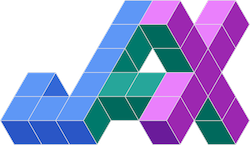

# JAX VMAP
When working on a codebase, it is important to consider the scalability and flexibility of the code. Let’s say you are working on a codebase designed to work with 1D arrays, but you realize that it would be beneficial to make the code compatible with batches of data. This is a common problem that many developers face when working with large datasets.

JAX VMAP can help you write concise and efficient code for machine learning research, especially when working with accelerators like GPUs and TPUs.

#### What is jax vmap?
jax vmap is a function that can be used to vectorize a function across a given axis. This means that the function can be applied to multiple inputs at the same time, which can significantly improve performance.

#### How do I use jax vmap?
The syntax for jax vmap is as follows:<br>
`jax.vmap(func, in_axes=None)`<br>
The func argument is the function that you want to vectorize. The in_axes argument is a list of axes that you want to vectorize over. If in_axes is None, then all axes will be vectorized.
#### What are some example of how to use jax vmap?
Here are some examples of how to use jax vmap:<br>

```
def f(x): return x * x 
    # Vectorize f over the first axis.
    g = jax.vmap(f, in_axes=(0,)) 
    
    # Apply g to a batch of inputs. 
    y = g(jnp.array([1, 2, 3])) 
    
    # y will be equal to [1, 4, 9]. 
def conv(x, w): return jnp.convolve(x, w, mode=”valid”) 
    # Vectorize conv over the first axis of x and the second axis of w. 
    h = jax.vmap(conv, in_axes=(0, 1)) 
    
    # Apply h to a batch of inputs. 
    z = h(jnp.array([1, 2, 3]), jnp.array([1, 2])) 
    
    # z will be equal to [2, 4].
```


In [1]:
from IPython.core.display import HTML
from IPython.display import display, Markdown
HTML("""
<style>
@import url("https://fonts.googleapis.com/css2?family=Raleway&family=Roboto:ital,wght@0,500;0,900;1,500&display=swap");
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    display: inline-block;
    text-align: center;
    padding: 30px;
    margin: 0;
    font-family: Raleway;
    background: linear-gradient(45deg, blue 40%, green);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    width: 90%;
    border-radius: 5px;
}

h2 {
    display: inline-block;
    text-align: center;
    padding: 25px;
    margin: 0;
    font-family: Raleway;
    background: linear-gradient(45deg, blue 40%, green);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    width: 90%;
    border-radius: 5px;
}

h3 {
    display: inline-block;
    text-align: center;
    padding: 20px;
    margin: 0;
    font-family: Raleway;
    background: linear-gradient(45deg, blue 40%, green);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    width: 90%;    
    border-radius: 5px;
}


body, p, ul, li {
    font-family: Raleway;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: Raleway;
    font-size: 20px;
    background: linear-gradient(to right, #30CFD0 0%, #121FCF 100%);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
}
</style>
""")

# Manual Vectorization
Consider the following simple code that computes the convolution of two one-dimensional vectors:

In [2]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

Suppose we would like to apply this function to a batch of weights `w` to a batch of vectors `x`.

In [3]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

The most naive option would be to simply loop over the batch in Python:

In [4]:
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

This produces the correct result, however it is not very efficient.

In order to batch the computation efficiently, you would normally have to rewrite the function manually to ensure it is done in vectorized form. This is not particularly difficult to implement, but does involve changing how the function treats indices, axes, and other parts of the input.

For example, we could manually rewrite `convolve()` to support vectorized computation across the batch dimension as follows:

In [5]:
def manually_vectorized_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1] -1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

manually_vectorized_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

Such re-implementation is messy and error-prone; fortunately JAX provides another way.

# Automatic Vectorization
In JAX, the `jax.vmap` transformation is designed to generate such a vectorized implementation of a function automatically:

In [6]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

It does this by tracing the function similarly to jax.jit, and automatically adding batch axes at the beginning of each input.

If the batch dimension is not the first, you may use the in_axes and out_axes arguments to specify the location of the batch dimension in inputs and outputs. These may be an integer if the batch axis is the same for all inputs and outputs, or lists, otherwise.

`jax.vmap` also supports the case where only one of the arguments is batched: for example, if you would like to convolve to a single set of weights w with a batch of vectors x; in this case the in_axes argument can be set to None:

In [7]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])

batch_convolve_v3(xs, w)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

# Combining transformations
As with all JAX transformations, `jax.jit` and `jax.vmap` are designed to be composable, which means you can wrap a vmapped function with jit, or a JITted function with vmap, and everything will work correctly:

In [8]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

# Conclusion
#### What are some of the benefits using jax vmap?
There are several benefits to using jax vmap, including:<br>
Improved performance: jax vmap can significantly improve the performance of functions that are applied to multiple inputs.<br>
Reduced memory usage: jax vmap can reduce the memory usage of functions that are applied to multiple inputs.<br>
Increased portability: jax vmap can make functions more portable, as they can be applied to inputs of different sizes.

#### What are some of the limitation of using jax vmap?
There are a few limitations to using jax vmap, including:
Not all functions can be vectorized: some functions cannot be vectorized, as they depend on the order of the inputs.
Can be difficult to debug: jax vmap can make it more difficult to debug functions, as the output of the function may be different when it is vectorized.
Can be inefficient for small inputs: jax vmap may not be efficient for small inputs, as the overhead of vectorization may outweigh the benefits.